In [39]:
# ECE661 HW7
# Zhengxin Jiang
# jiang839

import cv2
import numpy as np
import matplotlib . pyplot as plt
import math
from BitVector import * 
from vgg import * 
from skimage import io, transform
from sklearn import svm
import seaborn as sn 


num_trainc = 250
num_trainr = 165
num_trainsh = 203
num_trainsr = 307
num_testc = 50
num_testr = 50
num_testsh = 50
num_testsr = 50


# load train and test images
def loadImages():  
        
    train_imgset = []
    train_label = []
    test_imgset = []
    test_label = []
    
    # load images
    for i in range(1, num_trainc+1):
        img = cv2.imread('data/training/cloudy'+str(i)+'.jpg')
        train_imgset.append(img)
        train_label.append(0)
    
    for i in range(1, num_testc+1):
        img = cv2.imread('data/testing/cloudy'+str(i+num_trainc)+'.jpg')
        test_imgset.append(img)
        test_label.append(0)
        
    for i in range(1, num_trainr+1):
        img = cv2.imread('data/training/rain'+str(i)+'.jpg')
        train_imgset.append(img)
        train_label.append(1)
    
    for i in range(1, num_testr+1):
        img = cv2.imread('data/testing/rain'+str(i+num_trainr)+'.jpg')
        test_imgset.append(img)
        test_label.append(1)
        
    for i in range(1, num_trainsh+1):
        img = cv2.imread('data/training/shine'+str(i)+'.jpg')
        train_imgset.append(img)
        train_label.append(2)
    
    for i in range(1, num_testsh+1):
        img = cv2.imread('data/testing/shine'+str(i+num_trainsh)+'.jpg')
        test_imgset.append(img)
        test_label.append(2)
        
    for i in range(1, num_trainsr+1):
        img = cv2.imread('data/training/sunrise'+str(i)+'.jpg')
        train_imgset.append(img)
        train_label.append(3)
    
    for i in range(1, num_testsr+1):
        img = cv2.imread('data/testing/sunrise'+str(i+num_trainsr)+'.jpg')
        test_imgset.append(img)
        test_label.append(3)
        
    return train_imgset, train_label, test_imgset, test_label


# create a histogram using LBP
def lbpHist(image):
    
    img = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (64,64))

    del_l, del_k = 0.707, 0.707
    w_a = (1-del_l)*(1-del_k)
    w_d = del_l*del_k
    w_bc = (1-del_l)*del_k

    lbp_hist = np.zeros(10)

    # go through image pixels
    for i in range(1, img.shape[1]-1):
        for j in range(1, img.shape[0]-1):

            block = img[j-1:j+2, i-1:i+2].astype(int)

            # create pattern
            p = np.zeros(8)

            p[0] = block[2,1]
            p[1] = w_a*block[1,1] + w_bc*(block[2,1]+block[1,2]) + w_d*block[2,2]
            p[2] = block[1,2]
            p[3] = w_a*block[1,1] + w_bc*(block[0,1]+block[1,2]) + w_d*block[0,2]
            p[4] = block[0,1]
            p[5] = w_a*block[1,1] + w_bc*(block[0,1]+block[1,0]) + w_d*block[0,0]
            p[6] = block[1,0]
            p[7] = w_a*block[1,1] + w_bc*(block[2,1]+block[1,0]) + w_d*block[2,0]

            pattern = np.where(p>=block[1,1],1,0) 

            # minintval representation
            bv = BitVector(bitlist = list(pattern)) 
            intvals_for_circular_shifts = [int(bv << 1) for _ in range(8)] 
            minbv = BitVector(intVal = min(intvals_for_circular_shifts), size=8)
            bvruns = minbv.runs()

            # increment the corresponding bin
            if len(bvruns) > 2:
                lbp_hist[9] += 1
            elif len(bvruns) == 1 and bvruns[0][0] == '1':
                lbp_hist[8] += 1
            elif len(bvruns) == 1 and bvruns[0][0] == '0':
                lbp_hist[0] += 1
            else:
                lbp_hist[len(bvruns[1])] += 1

    return lbp_hist


# Calculate the gram matrix using the given image and model, 
# return the vector of the gram matrix using the given indices
def gramVec(image, model, indices):
    
    x = transform.resize(image, (256, 256))
    
    # feature map
    ft = vgg(x)
    ft = ft.reshape(512, 256)

    gram = ft.dot(ft.T)
    gram = gram[np.triu_indices(gram.shape[0])]  # upper triangle

    gramvec = gram[indices]

    return gramvec


# Calculate the AdaIN vector using the given image and model, 
def adainVec(image, model):
    
    x = transform.resize(image, (256, 256))
    
    # feature map
    ft = vgg(x)
    ft = ft.reshape(512, 256)

    mu = np.mean(ft, axis=1)
    mu_expand = np.tile(mu,(256,1)).T
    sigma = np.sqrt(np.mean(np.power(ft-mu_expand, 2), axis=1))

    vector = np.zeros(1024)
    for i in range(512):
        vector[i*2] = mu[i]
        vector[i*2+1] = sigma[i]

    return vector
    

# train a svm classifier and return the test confusion matrix
def svmConfusionMatrix(train_vec, test_vec, train_label, test_label):
    
    clf = svm.SVC()
    clf.fit(train_vec, train_label)
    
    predict = clf.predict(test_vec)

    cm = np.zeros((4,4))

    for i in range(len(test_vec)):
        cm[test_label[i], predict[i]] += 1
    
    return cm
    
    

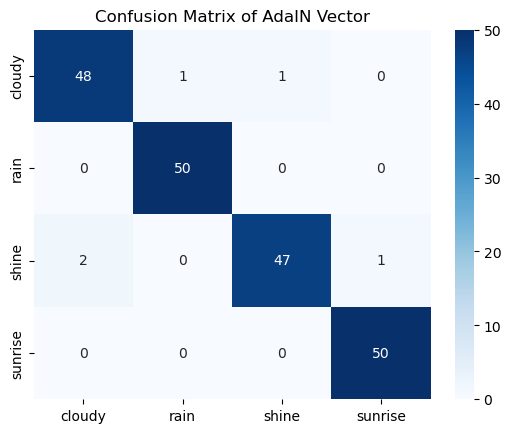

In [45]:
if __name__ == '__main__' :
    
    result_path = 'C:/Users/jzx/OneDrive - purdue.edu/ECE661/hw7/result images/'
    
    # load images
    train_imgset, train_label, test_imgset, test_label = loadImages()
    

    ### Task LBP ###
#     train_lbpvec = []
#     test_lbpvec = []

#     for i in range(len(train_imgset)):
#         train_lbpvec.append(lbpHist(train_imgset[i]))

#     for j in range(len(test_imgset)):
#         test_lbpvec.append(lbpHist(test_imgset[j]))

#     np.savez_compressed('lbp', train=train_lbpvec, test=test_lbpvec)
    
    loaded = np.load('lbp.npz')
    train_lbpvec = loaded['train']
    test_lbpvec = loaded['test']

    cm = svmConfusionMatrix(train_lbpvec, test_lbpvec, train_label, test_label)
    
    plt.figure()
    plt.title("Confusion Matrix of LBP, R = 1, P = 8") 
    sn.heatmap(cm, annot=True, cmap="Blues",xticklabels=['cloudy', 'rain', 'shine', 'sunrise'], yticklabels=['cloudy', 'rain', 'shine', 'sunrise'])

    
    ### Task Gram ###
#     train_gramvec = []
#     test_gramvec = []

#     vgg = VGG19()
#     vgg.load_weights('vgg_normalized.pth')

#     rand_indices = np.random.randint(131328, size = 1024)

#     for img in train_imgset:
#         train_gramvec.append(gramVec(img, vgg, rand_indices))

#     for img in test_imgset:
#         test_gramvec.append(gramVec(img, vgg, rand_indices))

#     np.savez_compressed('gram', train=train_gramvec, test=test_gramvec)

    loaded = np.load('gram.npz')
    train_gramvec = loaded['train']
    test_gramvec = loaded['test']
    
    cm_gram = svmConfusionMatrix(train_gramvec, test_gramvec, train_label, test_label)
    
    plt.figure()
    plt.title("Confusion Matrix of Gram Vector, vector size = 1024") 
    sn.heatmap(cm_gram, annot=True, cmap="Blues",xticklabels=['cloudy', 'rain', 'shine', 'sunrise'], yticklabels=['cloudy', 'rain', 'shine', 'sunrise'])
    
    
    ### Extra Credit AdaIN ###
#     train_adainvec = []
#     test_adainvec = []

#     vgg = VGG19()
#     vgg.load_weights('vgg_normalized.pth')

#     for img in train_imgset:
#         train_adainvec.append(adainVec(img, vgg))

#     for img in test_imgset:
#         test_adainvec.append(adainVec(img, vgg))

#     np.savez_compressed('adain', train=train_adainvec, test=test_adainvec)

    loaded = np.load('adain.npz')
    train_adainvec = loaded['train']
    test_adainvec = loaded['test']
    
    cm_adain = svmConfusionMatrix(train_adainvec, test_adainvec, train_label, test_label)
    
    plt.figure()
    plt.title("Confusion Matrix of AdaIN Vector") 
    sn.heatmap(cm, annot=True, cmap="Blues",xticklabels=['cloudy', 'rain', 'shine', 'sunrise'], yticklabels=['cloudy', 'rain', 'shine', 'sunrise'])



In [40]:
# load images
train_imgset, train_label, test_imgset, test_label = loadImages()

In [38]:
vgg = VGG19()
vgg.load_weights('vgg_normalized.pth')
# Read an image into numpy array

x = io.imread('data/training/sunrise1.jpg')
# Resize the input image
x = transform.resize(x, (256, 256))
# Obtain the output feature map
ft = vgg(x)
print(ft.shape)

ft = ft.reshape(512, 256)

mu = np.mean(ft, axis=1)
# print(mu.shape)
# print(mu)

# print(np.tile(mu, (256,1)).T)
mu_expand = np.tile(mu,(256,1)).T

sigma = np.sqrt(np.mean(np.power(ft-mu_expand, 2), axis=1))

vector = np.zeros(1024)
for i in range(512):
    vector[i*2] = mu[i]
    vector[i*2+1] = sigma[i]
    
print(vector)


(512, 16, 16)
[0.50873655 1.25431466 0.03657874 ... 0.75875342 0.21638364 0.64989209]


In [41]:
train_adainvec = []
test_adainvec = []

vgg = VGG19()
vgg.load_weights('vgg_normalized.pth')

for img in train_imgset:
    train_adainvec.append(adainVec(img, vgg))
    
for img in test_imgset:
    test_adainvec.append(adainVec(img, vgg))

In [42]:
np.savez_compressed('adain', train=train_adainvec, test=test_adainvec)

In [43]:
clf = svm.SVC()
clf.fit(train_adainvec, train_label)

SVC()

<AxesSubplot:title={'center':'Confusion Matrix of AdaIN Vector'}>

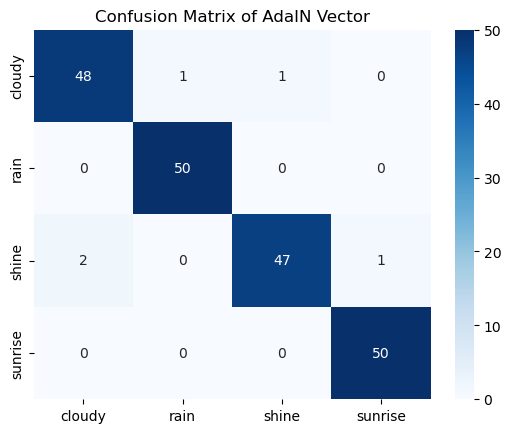

In [44]:
predict = clf.predict(test_adainvec)
# print(predict)
# print(test_label)

cm = np.zeros((4,4))

for i in range(len(test_adainvec)):
    cm[test_label[i], predict[i]] += 1

plt.figure()
plt.title("Confusion Matrix of AdaIN Vector") 
sn.heatmap(cm, annot=True, cmap="Blues",xticklabels=['cloudy', 'rain', 'shine', 'sunrise'], yticklabels=['cloudy', 'rain', 'shine', 'sunrise'])

Text(0.5, 1.0, 'LBP Hist of sunrise1')

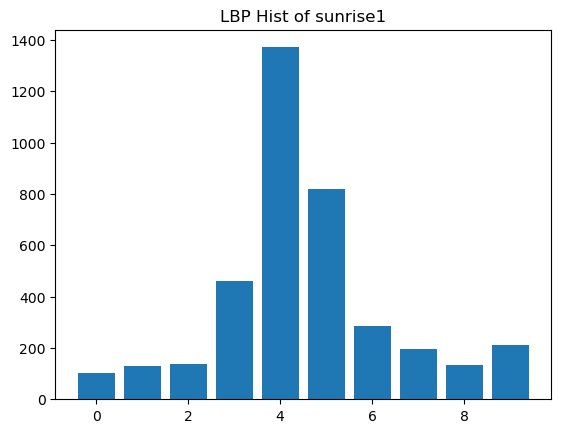

In [8]:
img = cv2.imread('data/training/sunrise1.jpg')
hist = lbpHist(img)

plt.bar(range(10),hist)
plt.title('LBP Hist of sunrise1') 


In [50]:
img = cv2.imread('data/training/shine131.jpg')
print(img)

[[[ 91  63  39]
  [ 93  64  43]
  [ 91  64  43]
  ...
  [ 94  62  43]
  [ 94  61  45]
  [ 94  61  45]]

 [[ 92  63  42]
  [ 93  64  43]
  [ 93  64  43]
  ...
  [ 94  62  43]
  [ 94  61  45]
  [ 94  61  45]]

 [[ 93  63  44]
  [ 93  63  44]
  [ 92  62  43]
  ...
  [ 92  62  45]
  [ 92  62  45]
  [ 92  62  45]]

 ...

 [[148 110  75]
  [149 111  76]
  [152 112  77]
  ...
  [176 159 138]
  [180 163 142]
  [209 192 171]]

 [[152 114  79]
  [152 114  79]
  [155 115  80]
  ...
  [205 191 172]
  [197 183 164]
  [215 201 182]]

 [[148 110  75]
  [149 111  76]
  [152 112  77]
  ...
  [205 192 176]
  [197 184 168]
  [205 192 176]]]
